# Modelling count data with Tensoflow Probability

In this notebook you will work with TFP. You will set up regression models that are able to output different conditional probability distributions to model count data. You will define different models with Keras, sklearn and the Tensorflow probability framework and optimize the negative log likelihood (NLL).
You compare the performace of the Poisson regression vs. the linear regression on a test dataset.

**Dataset:** 
You work with a camper dataset form https://stats.idre.ucla.edu/r/dae/zip/. The dataset contains data on 250 groups that went to a park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait  and whether or not they brought a camper to the park (camper).
You split the data into train and test dataset.

**Content:**
* Work with different distributions in TFP: Normal and Poisson
* Load and split the camper dataset 
* Fit different regression models to the camper train dataset: linar regression and Poisson regression 
* Plot the predicted probability distributions (CPD) for two specific datapoints along with their likelihood
* Plot the testdata along with the predicted mean and the 2.5% and 97.5% percentiles of the predicted CPD
* Compare the different models based on the test NLL 



In [39]:
!pip install tensorflow==2.1.0

In [40]:
!pip install tensorflow_probability==0.8.0

#### Imports

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf
import pandas as pd

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0
TF  Version 2.1.0


In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

### Loading real count data

Here you load the camper data from: https://stats.idre.ucla.edu/r/dae/zip/. The traget variable is the number of fish caught, during a state park visit by a group. You have data of 250 groups that went to the park. Each group was questioned about how many fish they caught (count), how many children were in the group (child), how many people were in the group (persons), if they used a live bait (livebait) and whether or not they brought a camper to the park (camper). This will be the features.
You randomly split the data into train and test dataset (80% train and 20% test).

In [0]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
y = dat[...,7]
X=np.array(X,dtype="float32")
y=np.array(y,dtype="float32")

Let's split the data and look at the counts (how many fish each group caught).


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
d = X_train.shape[1]
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape) 

(200, 4) (200,)
(50, 4) (50,)


In [45]:
print(y_test[0:10], y_train[0:10])

[0. 0. 2. 2. 0. 0. 0. 0. 1. 0.] [ 6.  1.  6.  1.  3.  1.  0. 15.  0.  2.]


In the following we will look at the number of fish each group caught. 

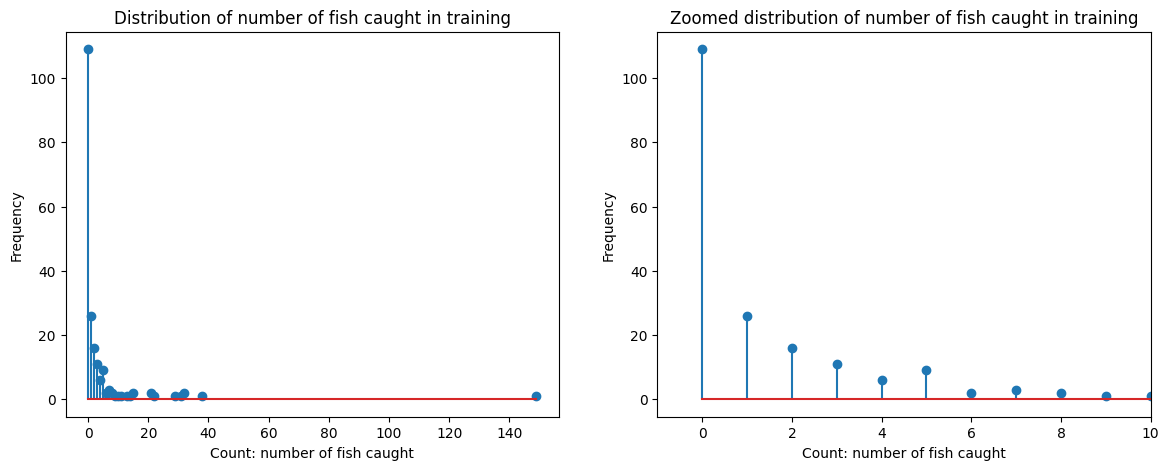

149.0

In [46]:
plt.figure(figsize=(14,5))

vals, counts = np.unique(y_train, return_counts=True)
plt.subplot(1,2,1)
plt.stem(vals, counts,use_line_collection=True)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.title('Distribution of number of fish caught in training')

plt.subplot(1,2,2)
plt.stem(vals, counts,use_line_collection=True)
plt.xlabel('Count: number of fish caught')
plt.ylabel('Frequency')
plt.xlim(-1,10)
plt.title('Zoomed distribution of number of fish caught in training')
plt.show()

np.max(y_train)

You see that most of the groups didn't catch any fish at all. Most of the groups were not very successful, but there is one group that was very successful and caught 149 fish!

Lets pick the two test observations 31 and 33, which you will investigate in the following. 

In [47]:
print(X_test[31])#"livebait","camper","persons","child
print(X_test[33])#"livebait","camper","persons","child
print(y_test[31])#"number of caught fish
print(y_test[33])#"number of caught fish

[1. 1. 4. 1.]
[1. 0. 4. 2.]
5.0
0.0


Group 31 used livebait, had a camper and were 4 persons with one child. They caught 5 fish.  
Group 33 used livebait, didn't have a camper and were 4 persons with two childern. They caught 0 fish.

## Zero inflated Poisson Regression 

You saw that there are a lot of unlucky groups that did not catch any fish at all. You will now define a model with two outputs, one for the poisson mean and one for the probability that zero fish were caught. This is the so called zero-inflated Poisson distribution. You use the TFP framework to create a mixture two processes: a Poission process and a zero generating process. You will not use any hidden layers in between and the loss will be the NLL. After the fitting, you predict the test data and compare the performance with the other models.



The ZIP distribution needs two parameters:
* rate: which defines the rate $\lambda$ of a Poisson process
* s: the probability to pick Poisson process (accordingly the zero-generating process is picked with probability 1-s)



In [0]:
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We used exponential to guaranty values > 0. We also used the squeeze function to flatten the tensor.
#B The second component codes for zero inflation; using the sigmoid squeezes the value between 0 and 1.
#C The two probabilities for 0’s or Poissonian distribution 
#D tfd.Categorical allows creating a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian distribution

In the next cell you can check if the ZIP distribution is working. As you can see in the code above, the zero_inf distribution takes two values as input. The first value controls the rate of the Poisson distribution and the second value controls the probability to pick the Poisson process. Both values can be negative or positive. To guarantee that the rate is a positive number, we transform the first argument with the exp() function.To guarantee that the probability s is a number between zero and one, we transform the second argument with the sigmoid() function.  

If the first argument is 1 then the rate of the Poisson process is exp(1) ~ 2.7. If the second argument is 10 then the probability to pick the Poisson process is sigmoid(10) ~ 0.9999. Accordingly, if the input to the zero_inf() distribution is 1 and 10, we would expect that we almost always take the Poisson process which has a rate parameter of ~ 2.7.  

If the input to the zero_inf() distribution is 1 and -10, we would expect that we almost always pick the zero-generating process. 
  
In the following cell you can check that the zero_inf function works as expected. It is also possible to sample from the distribution or calculate the mean.

In [49]:
## testinging the distribution, we evalute some data 

print("rate of the poissonian :", tf.exp(1.0).numpy())
print("probability to pick the poisson process :" ,tf.math.sigmoid(10.0).numpy())
print("probability to pick the poisson process :" ,tf.math.sigmoid(-10.0).numpy())


t = np.ones((2,2), dtype=np.float32)
t[0,0] = 1
t[0,1] = 10#almost always take pois 
t[1,0] = 1
t[1,1] = -10# almost always take zero
#t = tf.cast(t, dtype="float32")
print('Input Tensor : ')
print(t)
print('Output Mean  : ',zero_inf(t).mean().numpy())
print('Output Sample  : ',zero_inf(t).sample().numpy())

rate of the poissonian : 2.7182817
probability to pick the poisson process : 0.9999546
probability to pick the poisson process : 4.5397872e-05
Input Tensor : 
[[  1.  10.]
 [  1. -10.]]
Output Mean  :  [2.7181582e+00 1.2340420e-04]
Output Sample  :  [4. 0.]


Here you define the network and use the zero_inf distribution.



In [50]:
## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs) #A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done inside the zero_inf function
model_zi.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
distribution_lambda_1 (Distr ((None,), (None,))        0         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### Training using keras

In [0]:
def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

Text(0, 0.5, 'NLL')

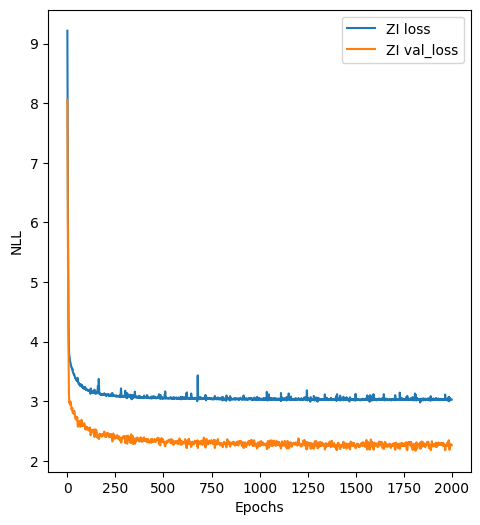

In [52]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['ZI loss','ZI val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')


#### Evaluation of the Performance 


In [53]:
model = Model(inputs=inputs, outputs=p_y_zi.mean()) 
y_hat_test = model.predict(X_test).flatten()


mse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_zi.evaluate(X_test, y_test) #returns the NLL 


df4 = pd.DataFrame(
         { 'RMSE' : mse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['ZIP (TFP)']
)
df4

50/50 [==============================] - 0s 99us/sample - loss: 2.2626


,RMSE,MAE,NLL (mean)
ZIP (TFP),7.387287,3.119298,2.262587


In the pandas dataframe above you see that the RMSE, MAE and the NLL of the diferent models. You see that the ZIP regression outperforms the Poisson and the Linear regression models  because of the lower NLL.

Let's plot the observed values vs the predicted mean of caught fish on the test dataset. To inicate the CPD you also plot  the 2.5% and 97.5% percentiles of the predicted CPD. You highlight the observations 31 and 33.

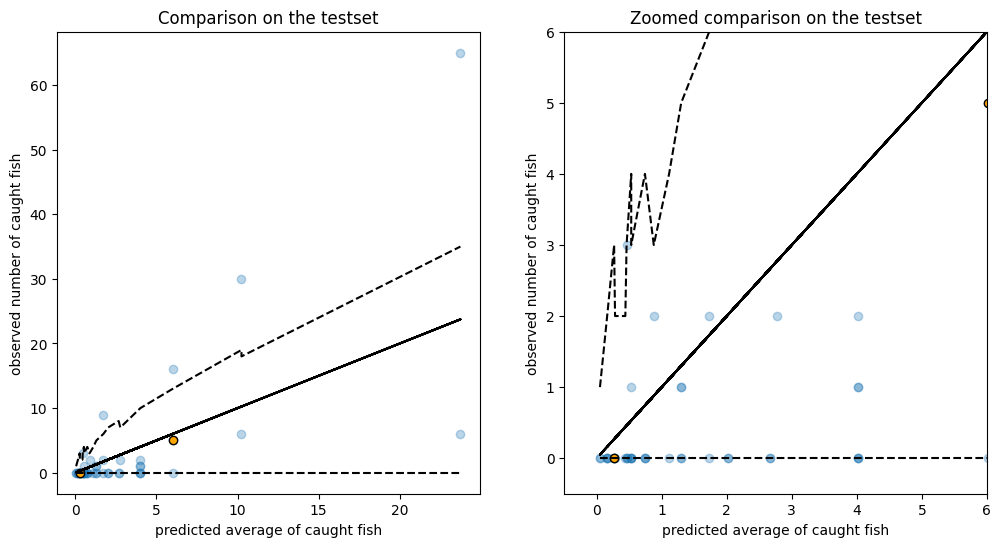

In [54]:
samples=model_zi(X_test).sample(5000).numpy()
lower=np.quantile(samples,0.025,axis=0)
upper=np.quantile(samples,0.975,axis=0)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")

plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")


plt.subplot(1,2,2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33],c="orange",marker='o',edgecolors= "black")
plt.scatter(y_hat_test[31], y_test[31],c="orange",marker='o',edgecolors= "black")

plt.title('Zoomed comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)],linestyle='dashed',c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5,6])
plt.ylim([-0.5,6])
plt.show()

Compared to the Poisson model it is striking that the 2.5% percentile is zero over the whole range. This is due the zero-inflated process modeling a higher amount of zeros compared to the Poisson process.

In [55]:
# Let's check the mean of the predicted CPDs for the obeservations nr 31 and 33
print(y_hat_test[31])
print(y_hat_test[33])
# Remember the observed nr of caught fish for the obeservations nr 31 and 33
print(y_test[31])
print(y_test[33])

6.0144963
0.2679385
5.0
0.0


Lets check the predicted outcome distribution for the observations 31 and 33.

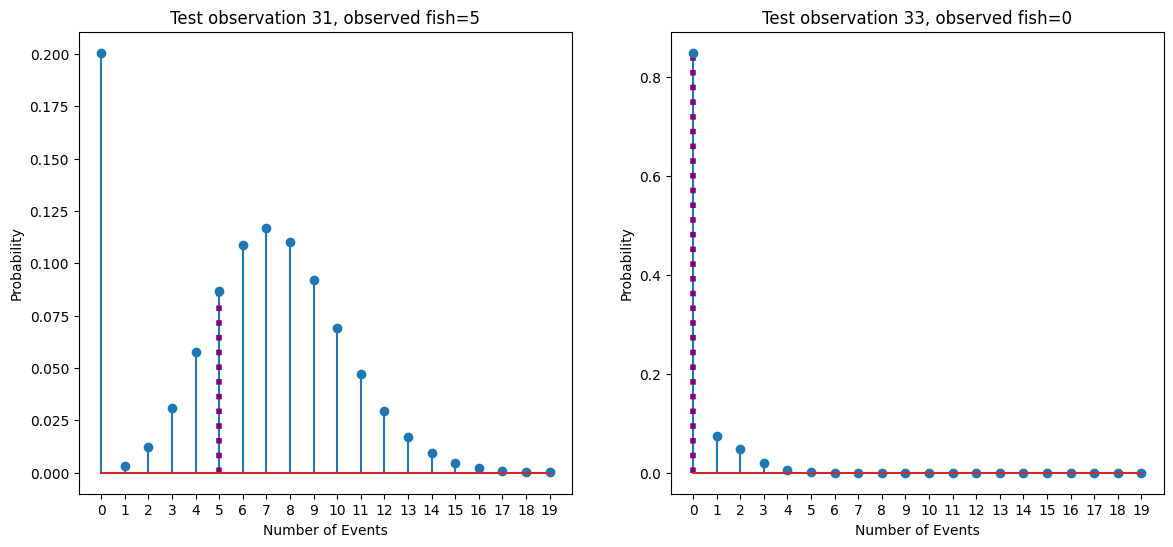

In [56]:
probs=model_zi(X_test).prob(np.arange(0,20,1).reshape(20,1)).numpy()
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.stem(np.arange(0,20,1),probs[:,31],use_line_collection=True)
plt.vlines(np.expand_dims(y_test,axis=1)[31], ymin=0, ymax=probs[np.int(y_test[31]),31],linestyle='dotted',color="purple",linewidth=4)
plt.xticks(np.arange(0,20,1))
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title('Test observation 31, observed fish=5')

plt.subplot(1,2,2)
plt.stem(np.arange(0,20,1),probs[:,33],use_line_collection=True)
plt.vlines(np.expand_dims(y_test,axis=1)[33], ymin=0, ymax=probs[np.int(y_test[33]),33],linestyle='dotted',color="purple",linewidth=4)
plt.xticks(np.arange(0,20,1))
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title('Test observation 33, observed fish=0')
plt.show()
#plt.savefig("zip_dist_31_33.pdf")
#from google.colab import files
#files.download('zip_dist_31_33.pdf')

You can see that the  predicted CPDs has a large peak at zero. This is due the zero-inflated process modeling a higher amount of zeros compared to the Poisson process.  
You can see that the liklihood of the observed values are quite high under the predicted CPDs (dotted line). Note that the ZIP CPD does only predict non-negative integer values which is a quite nice property for count data.
